# 使用卷积神经网络(CNN)识别手写体数字

In [2]:
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop, Adam
import numpy as np

Using TensorFlow backend.


## 1. 卷积神经网络(CNN)简介
如下图，这是一个多层的卷积神经网络示意图。
<ul>
<li>
输入层为224×224×3的图片数据
</li>
<li>
第一层是通过7*7的卷积核并使用步长为2的卷积操作，结果为110×100×96。
继续使用3×3，步长2的最大池操作，进一步得到55×55×96的输出。
</li>
<li>
第二层在第一层输出的55×55上进行5×5，步长2的卷积操作，结果得到26×26×256。
使用3×3，步长2的最大池操作，得到13×13×256的输出。
</li>
<li>
第三层和第四层是简单卷积层，卷积核3×3，步长为1，得到与原来相同的像素，但特征扩展到384。
</li>
<li>
第五层使用第四层结果，3*3卷积，步长1，得到13×13×256，继续使用3×3，步长2的最大池，得6×6×256的输出。
</li>
<li>
第六层和第七层为全连接层，最后使用softmax函数分类，得到结果。
</li>
</ul>
<p/>
<strong>** 图片摘自"Visualizing and Understanding Convolutional Networks" - Matthew D. Zeiler and Rob Fergus</strong>

<img src="../datasets/CNN.PNG"/>

## 2. 构建CNN模型
### 2.1 模型定义
使用类似VGG的方式构建CNN模型：
<ul>
<li>
输入层为28*28*1的手写体图片(黑白)；
</li>
<li>
使用3*3卷积核步长为缺省值1，激活函数使用relu，特征选择16，将得到28*28*16的输出。
</li>
<li>
重复使用上个层的处理，得到28*28*16输出。
</li>
<li>
使用2*2，步长2的最大池层，得到14*14*16输出。
</li>
<li>
使用3*3卷积核步长为缺省值1，激活函数使用relu，特征选择32，将得到14*14*32的输出。
</li>
<li>
使用3*3卷积核步长为缺省值1，激活函数使用relu，特征选择64，将得到14*14*64的输出。
</li>
<li>
使用全连接层，使用隐藏单元为128。
</li>
<li>
最后使用softmax函数把全连接层输出到10个分类(0-9)。
</li>
</ul>

In [3]:
def VGG_like(weights_path=None):
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(28,28,1)))
    model.add(Convolution2D(16, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(16, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    model.add(Dropout(0.25))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(32, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
#    model.add(Convolution2D(64, (3, 3), activation='relu'))
#    model.add(MaxPooling2D((2,2), strides=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    if weights_path:
        model.load_weights(weights_path)

    return model

In [4]:
model = VGG_like()
#sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
#model.compile(optimizer=sgd, loss='categorical_crossentropy')

### 2.2 CNN模型层次描述

In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1 (ZeroPaddin (None, 30, 30, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 30, 30, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 16)        0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 16, 16, 16)        0         
__________

## 3. 准备数据

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

### 3.1 下载手写数字数据集

In [7]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/")

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [8]:
mnist_images = mnist.train.images
mnist_labels = mnist.train.labels

In [9]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report
from sklearn import datasets

/opt/conda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### 3.2 分拆数据集为训练集和验证集
需要把标签数字调整为长度10的向量

In [10]:
trX, teX, trY, teY = train_test_split(mnist_images, mnist_labels.astype("int0"), test_size = 0.33)
print("Number of images for training:", trX.shape[0])
print("Number of images used for testing:", teX.shape[0])
pix = int(np.sqrt(teX.shape[1]))
print("Each image is:", pix, "by", pix, "pixels")
trX = trX.reshape(trX.shape[0],28,28,1)
teX = teX.reshape(teX.shape[0],28,28,1)


('Number of images for training:', 36850)
('Number of images used for testing:', 18150)
('Each image is:', 28, 'by', 28, 'pixels')


In [11]:
import keras as kr
teL = kr.utils.to_categorical(teY, 10)
trL = kr.utils.to_categorical(trY, 10)

## 4. 训练数据

In [18]:
model.compile(optimizer=Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

如果已经训练好，可以直接载入训练好的参数文件

In [20]:
model.load_weights("vgg_like.hdf5")

如果第一次，或者需要重新调整，可以进行数据训练

In [13]:
"""
model.fit(trX, trL, epochs=3,
            validation_data=(teX, teL), batch_size=64)

model.save_weights("vgg_like.hdf5")
"""

'\nmodel.compile(optimizer=Adam(lr=0.001),\n              loss=\'categorical_crossentropy\',\n              metrics=[\'accuracy\'])\nmodel.fit(trX, trL, epochs=3,\n            validation_data=(teX, teL), batch_size=64)\n\nmodel.save_weights("vgg_like.hdf5")\n'

根据测试集评估准确率

In [21]:
score = model.evaluate(teX, teL, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

('Test loss:', 0.04298104551467806)
('Test accuracy:', 0.98606060606060608)


## 5. 最后利用训练好模型对手写数字进行分类并展现

('Actual digit is', array([3]), 'predicted', array([ 0.  ,  0.  ,  0.  ,  0.99,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ]))


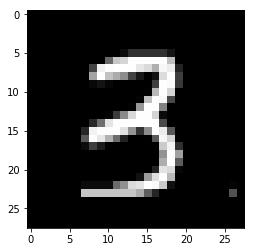

In [15]:
def randIm():
    i = np.random.choice(np.arange(0, len(teY)), size = (1,))
    pred = model.predict(teX[i].reshape(1, 28, 28,1))
    image = (teX[i] * 255).reshape((28, 28)).astype("uint8")
    # show the prediction
    print("Actual digit is", teY[i], "predicted", (pred[0]*100).astype("int")/100.0)
    imgplot = plt.imshow(image)
    imgplot.set_cmap('gray')   

randIm() 

('Actual digit is', array([7]), 'predicted', array([ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.99,  0.  ,  0.  ]))


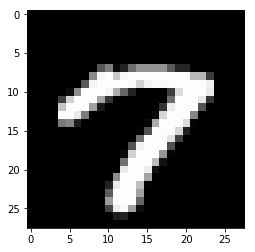

In [16]:
randIm() 

('Actual digit is', array([9]), 'predicted', array([ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.99]))


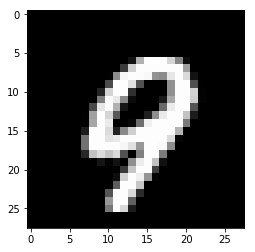

In [17]:
randIm() 


## 6. 小结

在这个示例中, 演示使用卷积神经网络CNN来对MNIST的手写体数字进行训练和识别分类。此案例可以帮助我们了解CNN的基本原理以及如何使用keras构建图片识别模型。相比DBN，我们得到了更高的精确率，如果机器允许，我们还可以增加filters等来继续提高精度。

## 作者

**李英伟 liyingw@cn.ibm.com ** 
